
Model Performance Comparison:
                                     MAE           RMSE        R²
Multiple Linear Regression  97470.454440  189581.301180  0.521794
Decision Tree               58064.272218  128762.694412  0.779401
Random Forest               56072.721971  127292.631672  0.784409
Gradient Boosting           68447.450997  144144.673580  0.723547


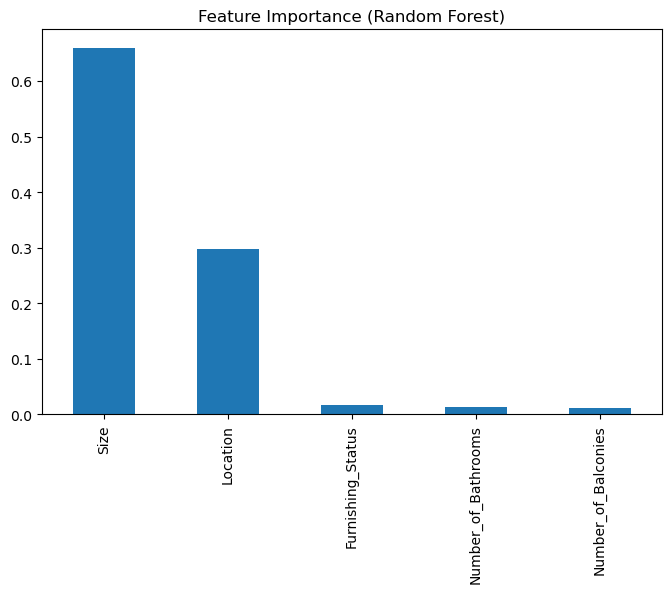

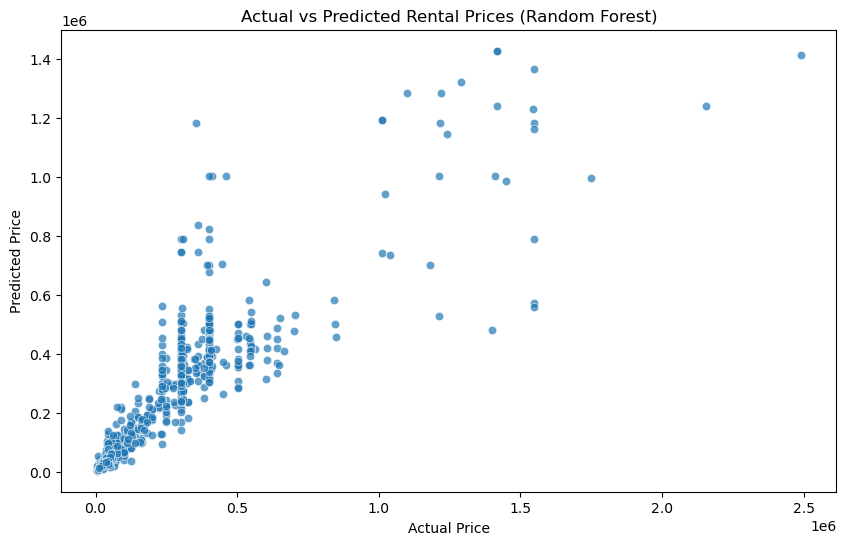

/Users/cm/Desktop/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


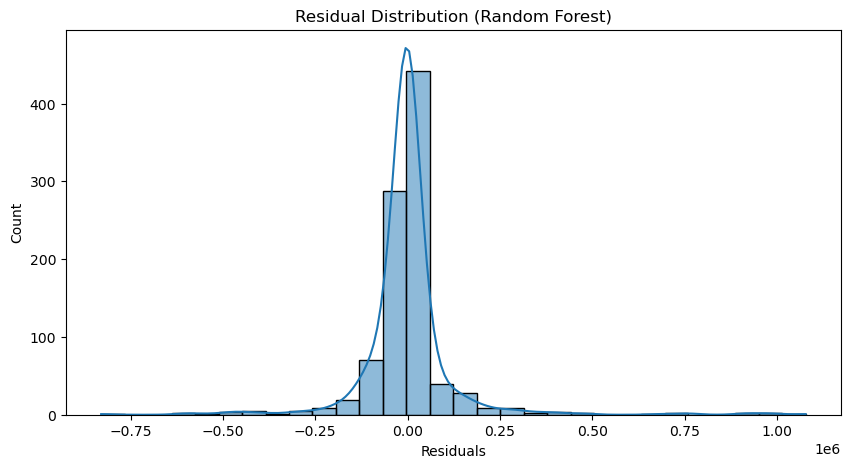

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load Dataset
df = pd.read_csv("/Users/cm/Desktop/Indian_housing_Delhi_data.csv")
df.dropna(inplace=True)  # Drop missing values

# Rename columns for consistency
df.rename(columns={
    'house_size': 'Size',
    'location': 'Location',
    'numBathrooms': 'Number_of_Bathrooms',
    'numBalconies': 'Number_of_Balconies',
    'price': 'Price'
}, inplace=True)

# ✅ Fix 'Size' Column: Convert '1,350 sq ft' → 1350
def clean_size(size):
    """Convert '1,350 sq ft' to a numeric format."""
    if isinstance(size, str):  
        size = re.sub(r'[^\d.]', '', size)  # Remove non-numeric characters
        return float(size) if size else np.nan  # Convert to float
    return size

df['Size'] = df['Size'].apply(clean_size)
df.dropna(subset=['Size'], inplace=True)  # Drop rows where size conversion failed

# ✅ Extract 'Furnishing_Status' from description
def extract_furnishing_status(description):
    """Extract furnishing status from the description text."""
    if isinstance(description, str):
        description = description.lower()
        if "fully furnished" in description:
            return "Fully Furnished"
        elif "semi furnished" in description:
            return "Semi Furnished"
        elif "unfurnished" in description:
            return "Unfurnished"
    return "Unknown"

df['Furnishing_Status'] = df['description'].apply(extract_furnishing_status)

# ✅ Encode Categorical Variables
le = LabelEncoder()
df['Furnishing_Status'] = le.fit_transform(df['Furnishing_Status'])
df['Location'] = le.fit_transform(df['Location'])

# ✅ Feature Selection
X = df[['Size', 'Location', 'Number_of_Bathrooms', 'Number_of_Balconies', 'Furnishing_Status']]
y = df['Price']

# ✅ Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Model Training & Evaluation
models = {
    "Multiple Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    results[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R²": r2_score(y_test, y_pred)
    }

# ✅ Convert results to DataFrame
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
print(results_df)

# ✅ Feature Importance (for Tree-based Models)
rf = models["Random Forest"]
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(8, 5), title="Feature Importance (Random Forest)")
plt.show()

# ✅ Visualization - Actual vs Predicted Prices (Best Model)
best_model_name = results_df["R²"].idxmax()  # Select model with highest R²
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.7)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title(f"Actual vs Predicted Rental Prices ({best_model_name})")
plt.show()

# ✅ Residual Plot
residuals = y_test - y_pred_best
plt.figure(figsize=(10, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residuals")
plt.title(f"Residual Distribution ({best_model_name})")
plt.show()
